In [23]:
import numpy as np
from numpy.typing import NDArray
import networkx as nx
from src.plotting import plot_graph, plot_loss_history
import matplotlib.pyplot as plt
NDArrayInt = NDArray[np.int_]

In [24]:
def plot_graph(
    loss_history: NDArrayInt, xlabel="# iterations", ylabel="# value"
) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    if loss_history.ndim == 1:
        loss_history = loss_history.reshape(1, -1)
    n_restarts, n_iters = loss_history.shape
    for i in range(n_restarts):
        ax.plot(range(n_iters), loss_history[i, :])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    fig.tight_layout()
    plt.show()


In [25]:
def set_colors(G, colors):
    for n, color in zip(G.nodes, colors):
        G.nodes[n]["color"] = color

In [26]:
def number_of_conflicts(G, colors):
    set_colors(G, colors)
    n = 0
    for n_in, n_out in G.edges:
        if G.nodes[n_in]["color"] == G.nodes[n_out]["color"]:
            n += 1
    return n

In [27]:
def tweak(colors, n_max_colors,G: nx.graph):
    new_colors = colors.copy()
    n_nodes = len(new_colors)
    
    random_index_start = np.random.randint(low=0, high=len(colors))
    node_color = colors[random_index_start]
    for i in nx.neighbors(G,random_index_start):
        neighbor_color = colors[i]
        while(neighbor_color == node_color):
            neighbor_color = np.random.randint(low=0, high=n_max_colors)
        new_colors[i] = neighbor_color
    return new_colors

In [28]:
def change(iteration_number):
    change = 1 / ( np.log(iteration_number + 330) * 0.1896 )
    return change

In [29]:
def temp_drop(current_temp,min_temp,max_temp,iteration_number) -> float:
    current_temp = current_temp * change(iteration_number)
    if(current_temp <= min_temp):
        current_temp = 0
    
    return current_temp

In [30]:
def probability(current_temp,delta_conflicts):
    probability_of_transition = 0
    if(current_temp != 0):
        power_of_e = (abs(delta_conflicts)/current_temp) # start = 0 end = inf
        probability_of_transition = np.exp(-1*power_of_e)
    return probability_of_transition

In [31]:
def solve_via_simulated_annealing (G: nx.Graph, n_max_colors: int, initial_colors: NDArrayInt, n_iters: int):
    current_iteration = 0
    global conflicts_list
    MIN_TEMP = 0.0000001
    MAX_TEMP = 500
    current_temp = MAX_TEMP
    cur_colors = initial_colors.copy()
    
    while(current_iteration < n_iters):
        next_colors = cur_colors.copy()
        next_colors = tweak(next_colors, n_max_colors,G)
    
        delta_conflicts = number_of_conflicts(G,cur_colors) - number_of_conflicts(G,next_colors)
        if(delta_conflicts > 0):
            cur_colors = next_colors
        else:
            if(current_temp > MIN_TEMP):
                probability_of_transition = probability(current_temp=current_temp,delta_conflicts=delta_conflicts)
                value = np.random.rand()
                if(value <= probability_of_transition):
                    cur_colors = next_colors
        current_temp = temp_drop(current_temp,MIN_TEMP,MAX_TEMP,current_iteration)
        conflicts_list[current_iteration] = number_of_conflicts(G,cur_colors)
        current_iteration += 1
        #print(f'---\n iteration_number = {current_iteration}, temp = {current_temp}, conflicts={number_of_conflicts(G,cur_colors)}, delta=  {delta_conflicts}\n---')
    #print(cur_colors)
    return cur_colors

In [32]:
MIN_TEMP = 0.0001
MAX_TEMP = 500
n_max_iters = 500
n_max_colors = 3
seed = 42
np.random.seed(seed)
G = nx.erdos_renyi_graph(n=100, p=0.05, seed=seed)
initial_colors = np.random.randint(low=0, high=n_max_colors - 1, size=len(G.nodes))


temp = MAX_TEMP

temp_list = np.zeros((n_max_iters,), dtype=np.float64)
probab_list = np.zeros((n_max_iters,), dtype=np.float64)
change_list = np.zeros((n_max_iters,), dtype=np.float64)
conflicts_list = np.zeros((n_max_iters,), dtype=np.float64)
final_coloring = np.array([])
for i in range(n_max_iters):
    temp = temp_drop(temp,MIN_TEMP,MAX_TEMP,i)
    change_list[i] = change(i)
    temp_list[i] = temp
    probab_list[i] = probability(temp,8)
final_coloring = solve_via_simulated_annealing(G, n_max_colors, initial_colors, n_max_iters)
print(f'FINAL NUMBER OF CONFLICTS = {conflicts_list[-1]}')



FINAL NUMBER OF CONFLICTS = 7.0


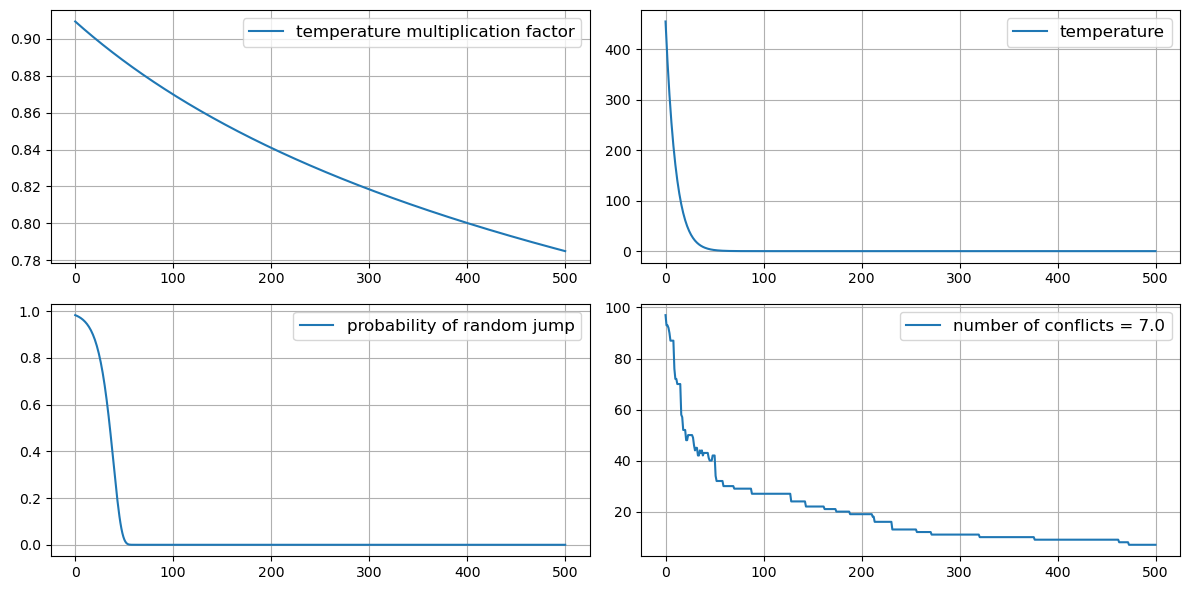

In [33]:
x = np.linspace(0,500,500) # Генерация равномерно точек 
y1 = change_list
y2 = temp_list
y3 = probab_list
y4 = conflicts_list

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6)) # Создает фигуру и оси ( 2 разных обьекта )
# Вернет массив 2х2 -> надо выбрать оси
ax[0,0].plot(x,y1,label="temperature multiplication factor")
ax[0,1].plot(x,y2 ,label="temperature")
ax[1,0].plot(x,y3 ,label="probability of random jump")
ax[1,1].plot(x,y4 ,label=f'number of conflicts = {conflicts_list[-1]}')

for axe in ax.reshape(-1):
    axe.grid() # TODO почитать про настройки
    axe.legend(loc="upper right",fontsize=12)

fig.tight_layout()
fig.savefig("result.png", dpi=300) # FIXME найти куда сохраняет ( в директорию откуда запущен питон ) 

plt.show() ## Всегда пишем в последний момент